# Neural Networks tutorial 03
## **Autoencoder** for unsupervised clustering of 4DSTEM data

This tutorial demonstrates how to use unsupervised learning and a convolutional autoencoder to cluster 4DSTEM diffraction patterns. Instead of predicting labels (supervised learning), the autoencoder learns to compress patterns into a low-dimensional "latent space" where similar patterns are close together.

An autoencoder is a neural network with two parts:
1. Encoder: Compresses input data into a compact representation (latent vector)
2. Decoder: Reconstructs the original input from the latent vector

The network learns by trying to reconstruct its input as accurately as possible. In doing so, the latent space learns to capture the essential features of the data.

## Requirements
- GPU recommended for training 
- Simulated polycrystalline WS2 dataset (download link provided below)

Arthur McCray  
Jan 7, 2026

In [1]:
%load_ext autoreload
%autoreload 2 

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm.auto import tqdm

import quantem as em 
from quantem.core import config
from quantem.core.ml import ConvAutoencoder2d
from quantem.core.visualization import show_2d

from importlib.metadata import version # Temporary fix for version check
print(f"quantEM version: {version("quantem")}")

print(f"Torch cuda is available: {torch.cuda.is_available()}")
print(f"Number of GPUs available: {torch.cuda.device_count()}")
GPU_ID = 0

config.set_device(GPU_ID)
print(f"Using GPU {config.get('device')} ({torch.cuda.get_device_name(GPU_ID)})")

/home/amccray/code/quantem/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch cuda is available: True
Number of GPUs available: 4
Using GPU cuda:0 (NVIDIA L40S)


# Step 1: Load 4DSTEM Dataset

We'll use a simulated polycrystalline WS2 dataset that contains diffraction patterns from multiple crystal grains with different orientations. Each grain should produce a distinct diffraction pattern.

Simulated polycrystalline WS2 data (originally from Py4DSTEM) can be downloaded [here](https://drive.google.com/file/d/1AWB3-UTPiTR9dgrEkNFD7EJYsKnbEy0y/view?usp=sharing) 

In [3]:
f_data = Path("~/data/example_data/polycrystal_2D_WS2.h5").expanduser()
print(f_data.exists())

True


keys:  ['4DSTEM', 'datacube', 'data']
Dataset shape (scan_y, scan_x, detector_y, detector_x): (128, 128, 128, 128)


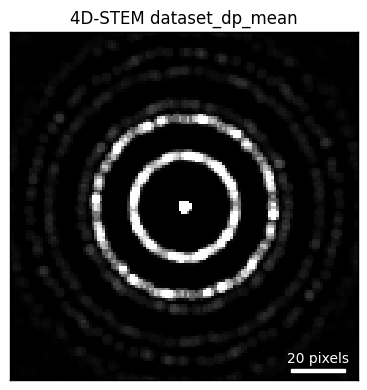

In [4]:
# Load 4DSTEM data from HDF5 file
dset = em.io.read_emdfile_to_4dstem(
    str(f_data),
    data_keys=["4DSTEM", "datacube", "data"],
    calibration_keys=["4DSTEM", "datacube", "calibration"],
)

# Set units and sampling
dset.units = ["pixels"] * 4
dset.sampling = [1] * 4

# Compute mean and max diffraction patterns for overview
dset.get_dp_mean()
dset.get_dp_max()
dset.dp_mean.show()
print(f"Dataset shape (scan_y, scan_x, detector_y, detector_x): {dset.shape}")

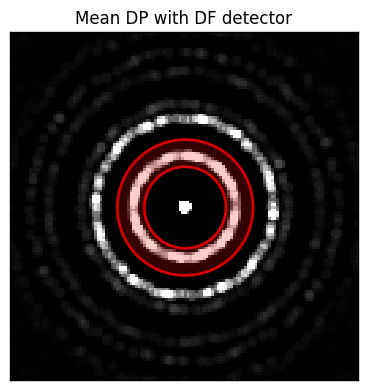

(<Figure size 600x600 with 1 Axes>, <Axes: title={'center': 'DF'}>)

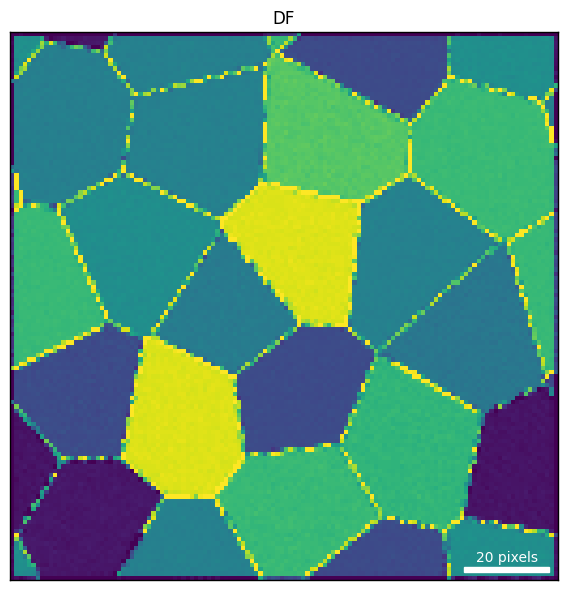

In [5]:
# Create a dark-field virtual image to visualize crystal grains
probe_qy0, probe_qx0 = dset.shape[2]//2, dset.shape[3]//2

dset.get_virtual_image(
    mode="annular",
    geometry=((probe_qy0, probe_qx0), (15, 25)),  # Center position, (inner_radius, outer_radius)
    name="DF",
    show=True,
)
dset.show_virtual_images(cmap='viridis')

# Step 2: Prepare Training Data

We will expand our training set with augmentation.

In [6]:
def augment_dataset(
    images, labels, augment_factor=2, dose:float | tuple[float, float] = 1e6, rng=None, flip=True, rotate=True
):
    """Data augmentation for diffraction patterns.
    
    Applies random rotations, flips, and Poisson noise to simulate realistic
    experimental variations. This helps the autoencoder generalize to noisy data.
    
    Args:
        images: Input diffraction patterns
        labels: Labels (same as images for autoencoders)
        augment_factor: Number of augmented copies per image
        dose: Electron dose for Poisson noise (higher = less noisy)
        rng: Random number generator for reproducibility
        flip, rotate: Whether to apply geometric transformations
    """
    if isinstance(dose, (int, float)):
        dose_range = [dose, dose]
    else:
        dose_range = dose
    augmented_images = []
    augmented_labels = []
    if rng is None:
        rng = np.random.default_rng()

    for img, lbl in tqdm(zip(images, labels), total=len(images)):
        for _ in range(augment_factor):
            img_aug = img.copy()
            lbl_aug = lbl.copy()
            if rotate:
                n_rot = int(rng.integers(0, 4))
                img_aug = np.rot90(img, k=n_rot, axes=(-2, -1))
                lbl_aug = np.rot90(lbl, k=n_rot, axes=(-2, -1))
            if flip:
                if rng.random() > 0.5:  # Random horizontal flip
                    img_aug = np.flip(img_aug, axis=-1)
                    lbl_aug = np.flip(lbl_aug, axis=-1)

                if rng.random() > 0.5:  # Random vertical flip
                    img_aug = np.flip(img_aug, axis=-2)
                    lbl_aug = np.flip(lbl_aug, axis=-2)

            if dose_range[1] > 0:
                rng_dose = rng.uniform(dose_range[0], dose_range[1])
                img_aug = noise_image_poisson(img_aug, dose=rng_dose, rng=rng)

            augmented_images.append(img_aug)
            augmented_labels.append(lbl_aug)

    augmented_images = np.stack(augmented_images, axis=0)  # (N, C, H, W)
    augmented_labels = np.stack(augmented_labels, axis=0)  # (N, H, W)

    return augmented_images, augmented_labels


def noise_image_poisson(image, dose=1e6, rng=None):
    """Add Poisson (shot) noise to simulate realistic electron counting statistics.
    
    Normalizes the image to the specified total electron dose, then applies
    Poisson noise. Lower dose = more noise, mimicking low-dose experimental conditions.
    """
    if rng is None:
        rng = np.random.default_rng()
    
    # Normalize to specified electron dose
    image = image / image.sum(axis=(-2, -1))[...,None,None] * dose 
    noisy_image = rng.poisson(image).astype(image.dtype)

    return noisy_image

In [7]:
# Reshape 4D dataset into 2D array: (total_scan_positions, detector_y, detector_x)
# This flattens the 2D scan into a list of diffraction patterns
dps = dset.array.reshape((-1, *dset.shape[2:]))
print(f"Reshaped diffraction patterns: {dps.shape}")

Reshaped diffraction patterns: (16384, 128, 128)


In [8]:
# Set random seeds for reproducibility
rng = np.random.default_rng(42)
rng_torch = torch.Generator().manual_seed(42)

# Apply Poisson noise with varying doses (1e5 to 1e7 electrons)
# Lower doses add more noise, helping the autoencoder learn robust features
noisy_dps, _nonoise_labels = augment_dataset(dps, dps, augment_factor=2, dose=(1e5, 1e7), rng=rng)


100%|██████████| 16384/16384 [00:11<00:00, 1377.63it/s]


(<Figure size 800x400 with 4 Axes>,
 array([<Axes: title={'center': 'Noisy (Input)'}>,
        <Axes: title={'center': 'Original (Before Noise)'}>], dtype=object))

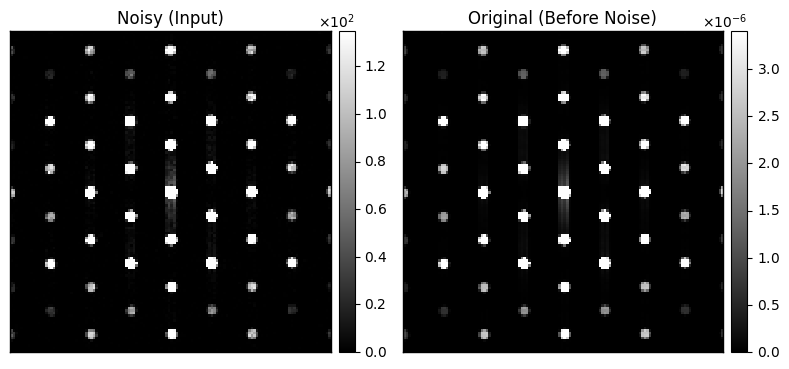

In [9]:
# Compare noisy vs original diffraction patterns
i = 1
show_2d([noisy_dps[i], _nonoise_labels[i]], cbar=True, title=['Noisy (Input)', 'Original (Before Noise)'])

# Step 3: Create PyTorch Dataset and DataLoaders

We'll create a custom Dataset class that applies a log transformation to the diffraction patterns. This helps handle the large dynamic range typical in electron diffraction data (bright central beam vs weak outer features).


In [10]:
class SimpleDPAutoencoderDataset(Dataset):
    """PyTorch Dataset for diffraction patterns with log scaling.
    
    Applies log(x+1) transformation to handle the large dynamic range in
    diffraction data (bright central beam, weak outer features).
    """
    def __init__(self, dps):
        # Apply log scaling: compresses dynamic range for better training
        self.dps = [torch.log(torch.tensor(dp, dtype=torch.float32)+1) for dp in dps]

    def __len__(self):
        return len(self.dps)

    def __getitem__(self, idx):
        return self.dps[idx]


# Create dataset from noisy diffraction patterns
dataset = SimpleDPAutoencoderDataset(noisy_dps)

# Split into train and validation sets
val_factor = 0.2
train_size = int((1 - val_factor) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=rng_torch)

print(f"Length of train dataset: {len(train_dataset)} | validation dataset: {len(val_dataset)}")

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f"Train loader batches: {len(train_loader)} | Validation loader batches: {len(val_loader)}")

Length of train dataset: 26214 | validation dataset: 6554
Train loader batches: 820 | Validation loader batches: 205


# Step 4: Create and Train the Autoencoder

Now we'll build the autoencoder architecture and train it to reconstruct diffraction patterns. The key is the **latent vector** - a compressed representation that captures the essential features of each pattern.


In [11]:
# Create the autoencoder model
# Key parameters:
# - latent_dim=64: Compress each diffraction pattern to 64 numbers
# - latent_normalization="l2": Normalize latent vectors for clustering
model = ConvAutoencoder2d(
    input_size=dataset[0].shape,
    start_filters=16,
    latent_dim=64,  # Dimensionality of the compressed representation
    num_layers=3,
    dtype=torch.float32,
    dropout=0,
    latent_normalization="l2",  # L2 normalization enables cosine similarity clustering
)

model = model.to(config.get("device"))

# Optimizer: Adam with learning rate scaled by batch size
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-5 * np.sqrt(batch_size)
)

# Loss function: Mean Squared Error between input and reconstruction
criterion = torch.nn.MSELoss()

# Track training progress
train_losses = []
val_losses = []

100%|██████████| 10/10 [02:41<00:00, 16.20s/it]


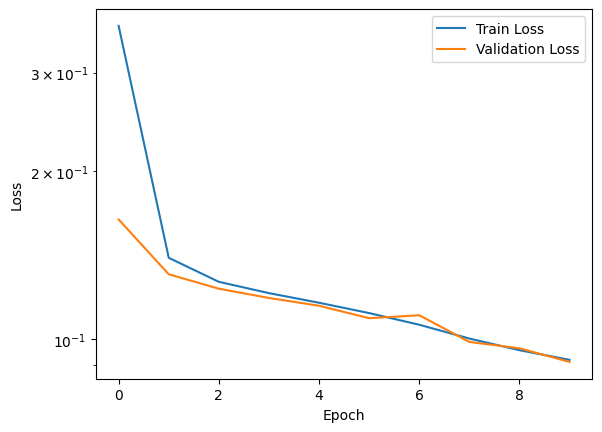

In [12]:
# Train for 25 epochs
# This is relatively fast since we only have ~2,500 diffraction patterns
num_epochs = 25

for epoch in tqdm(range(num_epochs)):
    ### TRAINING PHASE
    model.train()
    epoch_loss = 0
    for inputs in train_loader:
        # Add channel dimension: (batch, H, W) -> (batch, 1, H, W)
        inputs = inputs.to(config.get("device"))[:,None]

        optimizer.zero_grad()
        outputs, _ = model(inputs)  # outputs = reconstruction, _ = latent vector
        loss = criterion(inputs, outputs)  # Compare input to reconstruction
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    ### VALIDATION PHASE
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_loader:
            inputs = batch[:,None]
            inputs = inputs.to(config.get("device"))

            outputs, _ = model(inputs)
            loss = criterion(inputs, outputs)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

fig, ax = plt.subplots()
ax.semilogy(train_losses, label="Train Loss")
ax.semilogy(val_losses, label="Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()

**Note on the loss curves**: Our training and validation sets come from the same spatial regions (just shuffled), so they're not truly independent. This means we won't see the typical train/val separation even if the model overfits. In practice, you'd want to use spatially separated regions for validation to get a more realistic assessment. 

Latent similarity (dot product): 0.536


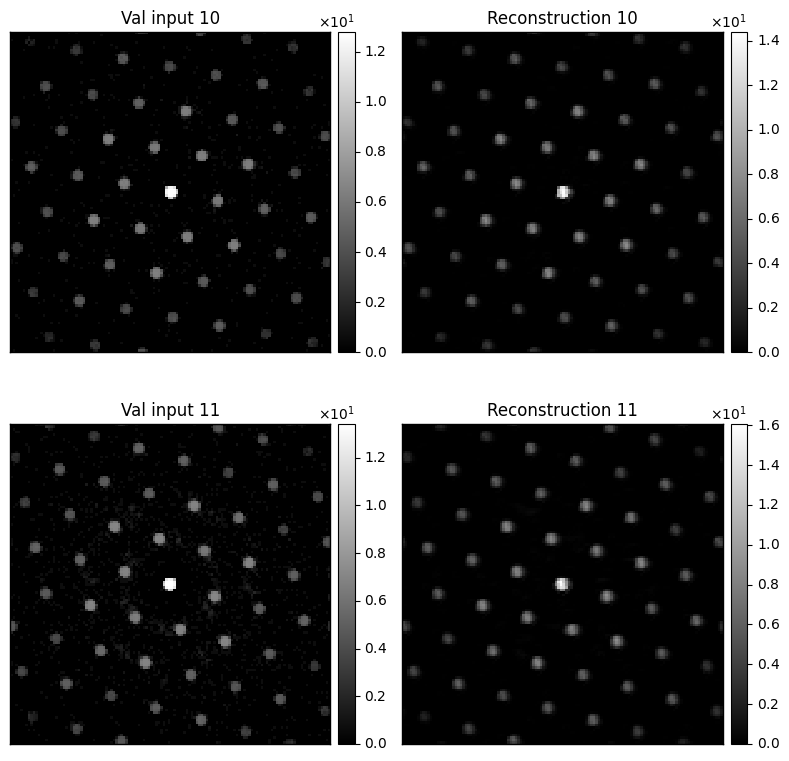

In [18]:
# Test the trained autoencoder on validation examples
i = 10

# Process two consecutive patterns and get their reconstructions and latent vectors
inp1 = val_dataset[i]
out1, latent1 = model.forward(inp1[None, None, ...].to(config.get_device()))
out1 = out1.squeeze().cpu().detach().numpy()

inp2 = val_dataset[i+1]
out2, latent2 = model.forward(inp2[None, None, ...].to(config.get_device()))
out2 = out2.squeeze().cpu().detach().numpy()

# Visualize input vs reconstruction for both patterns
show_2d(
    [
        [inp1.squeeze().cpu().detach().numpy(),
        out1.squeeze()],
        [inp2.squeeze().cpu().detach().numpy(),
        out2.squeeze()],
    ],
    cbar=True,
    norm="minmax",
    title=[
        [f"Val input {i}",
        f"Reconstruction {i}"],
        [f"Val input {i+1}",
        f"Reconstruction {i+1}"]
    ],
);

# Check similarity of latent vectors using dot product (L2 normalized)
# Values close to 1 = very similar patterns, close to 0 = different patterns
print(f"Latent similarity (dot product): {torch.dot(latent1.squeeze(), latent2.squeeze()):.3f}")


# Step 5: Apply Autoencoder to Full Dataset

Now we'll encode the entire 4DSTEM dataset to create a latent representation at each scan position. We can then use these latent vectors to cluster similar diffraction patterns.

It's important that preprocess the full dataset exactly as we did the training data:
1. Scale to a consistent dose (1e6 electrons, this would not be necessary if we had experimental data, but it would still be important that the dose is within the range of the training data). 
2. Apply log(x+1) transformation
3. Convert to torch tensors

If we skip these steps, the model will produce nonsense outputs even though it's correctly trained.

In [19]:
# Preprocess the full dataset: normalize to dose 1e7 and apply log transform
# This matches the preprocessing we did for training
dset_flat = np.log(dset.array.reshape((-1, *dset.shape[2:])) * 1e7 + 1)
dset_input = torch.tensor(dset_flat, dtype=torch.float32)

# Encode all diffraction patterns in batches (to avoid memory issues)
dset_features = [] 
batch_size = 100
for i in tqdm(range(0, len(dset_input), batch_size), desc="Encoding patterns"):
    # Get latent vectors using the encoder
    latent = model.encode(dset_input[i:i+batch_size][:,None].to(config.get("device")))
    dset_features.append(latent.cpu().detach().numpy().squeeze())

# Concatenate and reshape back to 2D scan grid
dset_features = np.concatenate(dset_features, axis=0)
dset_features = dset_features.reshape((*dset.shape[:2], -1))  # (scan_y, scan_x, latent_dim)
print(f"Encoded feature map shape: {dset_features.shape}")


Encoding patterns: 100%|██████████| 164/164 [00:00<00:00, 185.65it/s]

Encoded feature map shape: (128, 128, 64)


# Step 6: Cluster Latent Vectors to Segment Crystal Grains

Now that we have a 64-dimensional latent vector at each scan position, we need to group similar vectors to identify crystal grains. We'll use a simple region growing algorithm:

1. Start at an unvisited pixel and use its latent vector as a seed
2. Expand to neighboring pixels with similar latent vectors (cosine similarity > threshold)  
3. All connected similar pixels form one cluster (crystal grain)
4. Repeat until all pixels are assigned



In [23]:
def marching_clusters(encoded_map, similarity_threshold=0.8):
    """Region growing algorithm to cluster latent vectors.
    
    Grows spatially connected regions where neighboring pixels have similar
    latent representations (measured by cosine similarity).
    
    Args:
        encoded_map: (Ry, Rx, latent_dim) array of latent vectors at each position
        similarity_threshold: Cosine similarity threshold (0-1) for grouping
        
    Returns:
        labels: (Ry, Rx) array with cluster IDs for each position
    """
    Ry, Rx, latent_dim = encoded_map.shape
    labels = np.zeros((Ry, Rx), dtype=int)
    current_label = 1
    
    for i in range(Ry):
        for j in range(Rx):
            if labels[i, j] == 0:  # Unvisited pixel
                # Start new region from this seed
                seed_vector = encoded_map[i, j]
                region_mask = grow_region(encoded_map, seed_vector, 
                                        (i, j), similarity_threshold)
                labels[region_mask] = current_label
                current_label += 1
    
    return labels

def grow_region(encoded_map, seed_vector, start_pos, threshold):
    """Grow a connected region using breadth-first search.
    
    Starting from a seed position, expands to 4-connected neighbors whose
    latent vectors have cosine similarity > threshold with the seed.
    """
    from collections import deque
    
    Ry, Rx, _ = encoded_map.shape
    visited = np.zeros((Ry, Rx), dtype=bool)
    region_mask = np.zeros((Ry, Rx), dtype=bool)
    
    queue = deque([start_pos])
    visited[start_pos] = True
    
    while queue:
        x, y = queue.popleft()
        
        current_vector = encoded_map[x, y]
        
        # Compute cosine similarity between current pixel and seed
        seed_norm = np.linalg.norm(seed_vector)
        current_norm = np.linalg.norm(current_vector)
        
        if seed_norm > 0 and current_norm > 0:
            similarity = np.dot(seed_vector, current_vector) / (seed_norm * current_norm)
        else:
            similarity = 1.0 if seed_norm == current_norm == 0 else 0.0
        
        # If similar enough, add to region and check neighbors
        if similarity > threshold:
            region_mask[x, y] = True
            
            # Add 4-connected neighbors to queue
            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                nx, ny = x + dx, y + dy
                if (0 <= nx < Ry and 0 <= ny < Rx and 
                    not visited[nx, ny]):
                    visited[nx, ny] = True
                    queue.append((nx, ny))
    
    return region_mask

Initial number of clusters: 1413
After filtering (min_size=25): 29 clusters
Removed 1379 small clusters


(<Figure size 400x400 with 1 Axes>, <Axes: >)

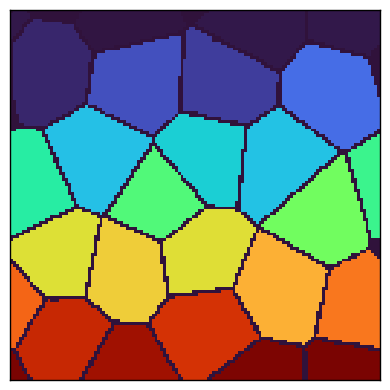

In [24]:
# Apply region-growing clustering to the latent space
# similarity_threshold=0.995 is very high (close to 1), requiring very similar patterns
# Lower values (e.g., 0.95) would merge more regions together
clustered_raw = marching_clusters(dset_features, similarity_threshold=0.999)

print(f"Initial number of clusters: {clustered_raw.max()}")

# Filter out small clusters (likely noise or boundaries)
min_grain_size = 25
counts = np.bincount(clustered_raw.ravel())
mask = counts >= min_grain_size
clustered = np.where(mask[clustered_raw], clustered_raw, 0)
        

print(f"After filtering (min_size={min_grain_size}): {len(np.unique(clustered))} clusters")
print(f"Removed {len(np.unique(clustered_raw)) - len(np.unique(clustered))} small clusters")
show_2d(clustered, cmap='turbo')

It's kind of hard to see which of the darker regions are connected, but pushing the background value down reveals that they are distinct. 

(<Figure size 400x400 with 1 Axes>, <Axes: >)

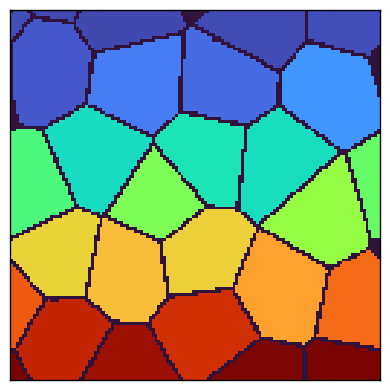

In [ ]:
clusterd_highlight_boundaries = np.where(clustered==0, -100, clustered)
show_2d(clusterd_highlight_boundaries, cmap='turbo')

-- end -- 